<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 2 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
### YOUR CODE STARTS HERE
import pandas as pd
from scipy.stats import ttest_ind

### Obtaining, cleaning and examing the data:

In [0]:
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
                          
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None, names=column_headers, na_values='?')

In [4]:
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [0]:
df = df.replace({'y': 1, 'n': 0})

In [6]:
df.groupby(by='party').mean()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
party,,,,,,,,,,,,,,,,
democrat,0.604651,0.502092,0.888462,0.054054,0.215686,0.476744,0.772201,0.828897,0.758065,0.471483,0.505882,0.144578,0.289683,0.350195,0.637450,0.935135
republican,0.187879,0.506757,0.134146,0.987879,0.951515,0.897590,0.240741,0.152866,0.115152,0.557576,0.132075,0.870968,0.860759,0.981366,0.089744,0.657534


###Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01

In [7]:
bud_res = ttest_ind(
    df[df['party'] == 'democrat']['budget'].dropna(),
    df[df['party'] == 'republican']['budget'].dropna()
    )
print(bud_res)

Ttest_indResult(statistic=23.21277691701378, pvalue=2.0703402795405602e-77)


In [8]:
bud_res.pvalue < 0.01

True

In [9]:
print(df[df['party'] == 'democrat']['budget'].mean())
print(df[df['party'] == 'republican']['budget'].mean())

0.8884615384615384
0.13414634146341464


Due to a p-value that is essentially 0 (2e-77), it is very likely that support for the bill 'budget' is greater among democrats.

###Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01

In [10]:
sue_res = ttest_ind(
    df[df['party'] == 'democrat']['right-to-sue'].dropna(),
    df[df['party'] == 'republican']['right-to-sue'].dropna()
    )
print(sue_res)

Ttest_indResult(statistic=-13.51064251060933, pvalue=1.2278581709672014e-34)


In [11]:
bud_res.pvalue < 0.01

True

In [12]:
print(df[df['party'] == 'democrat']['right-to-sue'].mean())
print(df[df['party'] == 'republican']['right-to-sue'].mean())

0.2896825396825397
0.8607594936708861


Due to a p-value that is essentially 0 (1e-34), it is very likely that support for the bill 'budget' is greater among republicans.

### Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

In [13]:
imm_res = ttest_ind(
    df[df['party'] == 'democrat']['immigration'].dropna(),
    df[df['party'] == 'republican']['immigration'].dropna()
    )
print(imm_res)

Ttest_indResult(statistic=-1.7359117329695164, pvalue=0.08330248490425282)


In [14]:
imm_res.pvalue / 2 < 0.01

False

In [15]:
print(df[df['party'] == 'democrat']['immigration'].mean())
print(df[df['party'] == 'republican']['immigration'].mean())

0.4714828897338403
0.5575757575757576


Given a p-value of .0416 (two-tailed) and alpha of .01, I fail to reject the hypothesis that democrats and republicans have similar support on the 'immigration' bill.

###Refactor your code into functions so it's easy to rerun with arbitrary variables

In [0]:
from scipy.stats import ttest_1samp

In [0]:
def my_ttest(df, on, subclasses, test_col, test_confidence,
             test_mean=None, plot_dist=True):
  '''Return a t-test comparing one sample to a test mean (independent t-test)
  or comparing two samples to each other.

  Parameters:
      df : pd.DataFrame
        a pandas DataFrame object
      on : str
        the DataFrame column containing the group(s) to be compared
      subclasses : str or list
        the name(s) of the group(s) to be compared
      test_col : str
        the name of the column containing the data used for comparison
      test_confidence : float
        the significance level (alpha) used for the t-test
      test_mean : float, optional
        the test mean for single-variable t-tests
      plot_dist : boolean, optional
        if True, a plot of tested data will be included in output

  Returns:
      Prints the following data:
        t-test analysis
        Relevant statistics:
          t-stat
          p-value
          means
      Density plot of tested groups (optional)
  '''

  import seaborn as sns

  res_lst = ['','']

  if test_mean:
    try:
      tstat, pval = ttest_1samp(df[df[on] == subclasses]
                                           [test_col].dropna(),
                                           test_mean)
      if plot_dist:
        sns.kdeplot((df[df[on] == subclasses][test_col].dropna()),
                    label=subclasses)
      subclasses = [subclasses]
      subclasses.append(str(test_mean))
      means = [f'{subclasses[0]} {on} mean: '
               f'{ df[df[on] == subclasses[0]][test_col].mean():,.4f}',
               f'Test mean: {test_mean}']
    except KeyError:
      print(f'{subclasses} not found in DataFrame.')
      return None
    except ValueError:
      print('Too many subclasses passed to function with test_mean.\n'
            'Use test_mean only for 1-sample t-tests.'
            )
      return None
    except (NameError, TypeError):
      print('Invalid DataFrame')
      return None
  
  elif len(subclasses) != 2:
    print('Incorrect number of sublasses passed to function.\n'
          'Expected list of two elements as second argument.'
          )
    return None

  else:
    tstat, pval = (ttest_ind(df[df[on] == subclasses[0]]
                                        [test_col].dropna(),
                                        df[df[on] == subclasses[1]]
                                        [test_col].dropna())
                              )
    if plot_dist:
        for subclass in subclasses:
          sns.kdeplot(df[df[on] == subclass][test_col].dropna(), label=subclass)
    
    means = [f'{subclasses[0]} {on} mean: '
               f'{ df[df[on] == subclasses[0]][test_col].mean():,.4f}',
             f'{subclasses[1]} {on} mean: '
               f'{ df[df[on] == subclasses[1]][test_col].mean():,.4f}']
    subclasses[1] = 'the "' + str(subclasses[1]) + f'" {on}'
  conf_lev = (1 - test_confidence) * 100
  if pval < test_confidence:
    conf_text = 'CAN'
  else:
    conf_text = 'can NOT'
  print(f'At a confidence level of {conf_lev}%, we {conf_text} say that the '
         f'"{subclasses[0]}" {on} level of "{test_col}" is significantly '
         f'different than {subclasses[1]}.\n\n'
         f'Relevant figures:\n'
         f'\tt-statistic: {tstat:,.4f}\n'
         f'\tp-value: {pval:.15f}\n'
         f'\t{means[0]:}\n'
         f'\t{means[1]}\n')

In [231]:
help(my_ttest)

Help on function my_ttest in module __main__:

my_ttest(df, on, subclasses, test_col, test_confidence, test_mean=None, plot_dist=True)
    Return a t-test comparing one sample to a test mean (independent t-test)
    or comparing two samples to each other.
    
    Parameters:
        df : pd.DataFrame
          a pandas DataFrame object
        on : str
          the DataFrame column containing the group(s) to be compared
        subclasses : str or list
          the name(s) of the group(s) to be compared
        test_col : str
          the name of the column containing the data used for comparison
        test_confidence : float
          the significance level (alpha) used for the t-test
        test_mean : float, optional
          the test mean for single-variable t-tests
        plot_dist : boolean, optional
          if True, a plot of tested data will be included in output
    
    Returns:
        Prints the following data:
          t-test analysis
          Relevant statist

At a confidence level of 99.0%, we CAN say that the "republican" party level of "immigration" is significantly different than 0.9.

Relevant figures:
	t-statistic: -8.8291
	p-value: 0.000000000000002
	republican party mean: 0.5576
	Test mean: 0.9



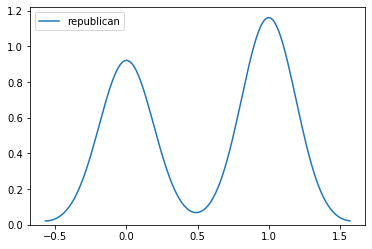

In [226]:
my_ttest(df, 'party', 'republican', 'immigration', .01, test_mean=.9)

At a confidence level of 99.0%, we can NOT say that the "democrat" party level of "immigration" is significantly different than the "republican" party.

Relevant figures:
	t-statistic: -1.7359
	p-value: 0.083302484904253
	democrat party mean: 0.4715
	republican party mean: 0.5576



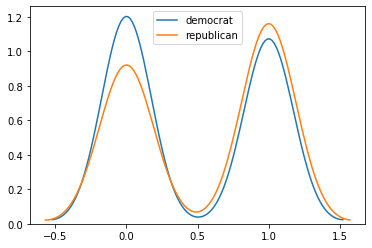

In [227]:
my_ttest(df, 'party', ['democrat', 'republican'], 'immigration', .01)

In [0]:
from sklearn.datasets import load_wine
X = load_wine()
wine = pd.DataFrame(X['data'], columns=X['feature_names'])
wine['origin'] = X['target']

At a confidence level of 95.0%, we CAN say that the "0" origin level of "ash" is significantly different than the "1" origin.

Relevant figures:
	t-statistic: 4.2899
	p-value: 0.000034928138984
	0 origin mean: 2.4556
	1 origin mean: 2.2448



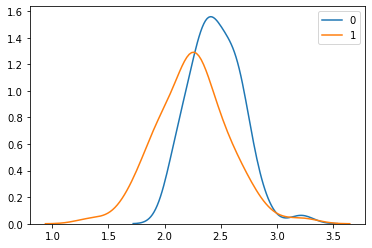

In [229]:
my_ttest(wine, 'origin', [0, 1], 'ash', .05)

In [230]:
my_ttest(df, 'party', ['democrat', 'republican'], 'budget', .01, plot_dist=False)

At a confidence level of 99.0%, we CAN say that the "democrat" party level of "budget" is significantly different than the "republican" party.

Relevant figures:
	t-statistic: 23.2128
	p-value: 0.000000000000000
	democrat party mean: 0.8885
	republican party mean: 0.1341

